# Structural Complexity Analysis - Rating Difficulty Experiment

This notebook performs an experiment to identify which ratings are most difficult to predict under structural perturbation. The analysis:

1. Loads and preprocesses a recommendation dataset
2. Partitions the training data into n groups
3. Applies structural perturbation to each partition
4. Computes squared prediction errors for each rating
5. Analyzes model performance when trained on the most difficult ratings

This helps understand which data points contribute most to model complexity and predictability.

In [60]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import os
import torch

# Import from structural_perturbation module (unchanged)
from structural_perturbation import (
    convert_to_sparse_matrix,
    compute_perturbation_impact
)

# Import RecBole libraries
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.utils import init_seed, init_logger, get_model, get_trainer
from recbole.data.dataloader import TrainDataLoader, FullSortEvalDataLoader

# Set random seed for reproducibility
np.random.seed(42)
init_seed(42, True)

print("All modules imported successfully!")

All modules imported successfully!


In [61]:
import warnings

# Silenciar pandas FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Silenciar deprecations de PyTorch
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [62]:
def temporal_holdout_split(df, test_ratio=None, leave_n_out=1):
    """
    Split data into train and test sets based on temporal holdout.
    
    If timestamp column is missing, uses sequential order (row order) as proxy.
    """
    # Check if timestamp column exists
    has_timestamp = 'timestamp' in df.columns
    
    if not has_timestamp:
        print("  Warning: No timestamp column found. Using sequential order for split.")
        # Add a fake sequential timestamp for splitting
        df = df.copy()
        df['timestamp'] = range(len(df))
    
    if test_ratio:
        cutoff_indices = df.groupby('user_id').cumcount() / df.groupby('user_id')['user_id'].transform('count')
        train_df = df[cutoff_indices < (1 - test_ratio)]
        test_df = df[cutoff_indices >= (1 - test_ratio)]
    elif leave_n_out:
        cutoff_indices = df.groupby('user_id').cumcount()
        train_df = df[cutoff_indices < (df.groupby('user_id')['user_id'].transform('count') - leave_n_out)]
        test_df = df[cutoff_indices >= (df.groupby('user_id')['user_id'].transform('count') - leave_n_out)]
    else:
        raise ValueError("Either test_ratio or leave_n_out must be provided.")
    
    # Remove fake timestamp if we added it
    if not has_timestamp:
        train_df = train_df.drop(columns=['timestamp'])
        test_df = test_df.drop(columns=['timestamp'])
    
    return train_df, test_df

In [ ]:
def train_model_with_fixed_test(train_sample_df, global_test_df, model_type='BPR', config_dict=None):
    """
    Train a RecBole model on a sample and evaluate on a fixed global test set.

    This ensures fair comparison by:
    1. Combining train_sample with global_test into one dataset
    2. Using RecBole's data_preparation to separate them
    3. Training only on train_sample
    4. Evaluating on the same global_test for ALL models

    Parameters:
    -----------
    train_sample_df : pd.DataFrame
        Training sample with [user_id, item_id, rating, timestamp]
    global_test_df : pd.DataFrame
        Fixed global test set (SAME for all models)
    model_type : str
        One of ['BPR', 'NeuMF', 'LightGCN', 'FM', etc.]
    config_dict : dict, optional
        RecBole configuration overrides

    Returns:
    --------
    model : RecBole model
    config : Config
    trainer : Trainer
    dataset : Dataset
    test_data : DataLoader
    """
    # Step 1: Combine train + test
    train_sample_df = train_sample_df.copy()
    global_test_df = global_test_df.copy()
    combined_df = pd.concat([train_sample_df, global_test_df], ignore_index=True)

    # Step 2: Save to RecBole format
    # temp_dataset_name = f'temp_train_{np.random.randint(100000)}'
    temp_dataset_name = 'temp_train'
    save_recbole_format(combined_df, temp_dataset_name)

    # Step 3: Configure RecBole with manual split
    n_train = len(train_sample_df)
    n_test = len(global_test_df)

    base_config = {
        'model': model_type,
        'dataset': temp_dataset_name,
        'data_path': 'dataset/',
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'RATING_FIELD': 'rating',
        'TIME_FIELD': 'timestamp',
        'load_col': {'inter': ['user_id', 'item_id', 'rating', 'timestamp']},

        # Training parameters
        'epochs': 50,
        'train_batch_size': 2048,
        'eval_batch_size': 4096,
        'learning_rate': 0.001,
        'embedding_size': 64,

        # CRITICAL: Use ratio split to separate train from test
        'eval_args': {
            'split': {'RS': [n_train, 0, n_test]},  # Exact counts - KEY FIX
            'mode': 'full',
            'order': 'RO'  # Respect order (train first, then test)
        },

        # Metrics
        'topk': [5, 10, 15],
        'valid_metric': 'NDCG@10',
        'metrics': ['Recall', 'Precision', 'NDCG', 'Hit', 'MRR', 'MAP'],
        'train_neg_sample_args': {'distribution': 'uniform', 'sample_num': 1},

        # System
        'seed': 42,
        'reproducibility': True,
        'show_progress': False,
        'save_dataset': False,
        'save_dataloaders': False
    }

    if config_dict:
        base_config.update(config_dict)

    # Step 4: Create dataset and dataloaders
    config = Config(model=model_type, dataset=temp_dataset_name, config_dict=base_config)
    dataset = create_dataset(config)
    train_data, valid_data, test_data = data_preparation(config, dataset)

    # Step 5: Train model
    model = get_model(config['model'])(config, train_data.dataset).to(config['device'])
    trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)

    best_valid_score, best_valid_result = trainer.fit(
        train_data, valid_data, saved=False, show_progress=False
    )

    return model, config, trainer, dataset, test_data


def evaluate_model(model, config, trainer, test_data_loader, k=10):
    """
    Evaluate RecBole model on the provided test data loader.

    Parameters:
    -----------
    model : RecBole model
    config : Config
    trainer : Trainer
    test_data_loader : DataLoader
    k : int

    Returns:
    --------
    precision : float
    ndcg : float
    map_at_k : float
    """
    test_result = trainer.evaluate(
        test_data_loader,
        load_best_model=False,
        show_progress=False
    )

    if test_result is None:
        return 0.0, 0.0, 0.0

    precision = test_result.get(f'precision@{k}', 0.0)
    ndcg = test_result.get(f'ndcg@{k}', 0.0)
    map_at_k = test_result.get(f'map@{k}', 0.0)

    return precision, ndcg, map_at_k

## Dataset Loading and Preprocessing Functions

In [64]:
MIN_RATINGS = 5       # Minimum ratings per user/item
MAX_USERS = 100000     # Maximum number of users to keep
MAX_ITEMS = 100000     # Maximum number of items to keep
N_PARTITIONS = 10      # Number of partitions for perturbation analysis
N_COMPONENTS = 100     # Number of SVD components for perturbation
MODEL_TYPE = 'LightGCN'     # RecBole model type

print(f"Configuration variables loaded:")
print(f"  MIN_RATINGS: {MIN_RATINGS}")
print(f"  MAX_USERS: {MAX_USERS}")
print(f"  N_PARTITIONS: {N_PARTITIONS}")
print(f"  N_COMPONENTS: {N_COMPONENTS}")
print(f"  MODEL_TYPE: {MODEL_TYPE}")


# Missing function: save_recbole_format
def save_recbole_format(df, dataset_name, output_path='dataset/'):
    """Save DataFrame to RecBole's .inter format."""
    dataset_dir = os.path.join(output_path, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)
    inter_file = os.path.join(dataset_dir, f'{dataset_name}.inter')

    df_export = df.copy()
    if 'timestamp' in df_export.columns and pd.api.types.is_datetime64_any_dtype(df_export['timestamp']):
        df_export['timestamp'] = df_export['timestamp'].astype('int64') // 10**9

    if df_export['user_id'].dtype == 'object':
        user_map = {old_id: new_id for new_id, old_id in enumerate(df_export['user_id'].unique())}
        df_export['user_id'] = df_export['user_id'].map(user_map)

    if df_export['item_id'].dtype == 'object':
        item_map = {old_id: new_id for new_id, old_id in enumerate(df_export['item_id'].unique())}
        df_export['item_id'] = df_export['item_id'].map(item_map)

    with open(inter_file, 'w') as f:
        header_cols = ['user_id:token', 'item_id:token', 'rating:float']
        if 'timestamp' in df_export.columns:
            header_cols.append('timestamp:float')
        f.write('\t'.join(header_cols) + '\n')

    cols_to_write = ['user_id', 'item_id', 'rating']
    if 'timestamp' in df_export.columns:
        cols_to_write.append('timestamp')

    df_export[cols_to_write].to_csv(inter_file, sep='\t', mode='a', header=False, index=False)
    return dataset_dir


# Missing function: preprocess_data
def preprocess_data(df, min_r=10, max_n=100000):
    """Preprocess dataset by filtering and subsampling users and items."""
    if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Sort by user_id and timestamp (if available)
    sort_cols = ['user_id']
    if 'timestamp' in df.columns:
        sort_cols.append('timestamp')
    df = df.sort_values(by=sort_cols)

    user_ratings_count = df['user_id'].value_counts()
    valid_users = user_ratings_count[user_ratings_count >= min_r].index
    df_filtered = df[df['user_id'].isin(valid_users)]

    item_ratings_count = df_filtered['item_id'].value_counts()
    valid_items = item_ratings_count[item_ratings_count >= min_r].index
    df_filtered = df_filtered[df_filtered['item_id'].isin(valid_items)]

    n_users = len(valid_users)
    if n_users > max_n:
        sampled_users = np.random.choice(valid_users, size=max_n, replace=False)
        df_filtered = df_filtered[df_filtered['user_id'].isin(sampled_users)]

    n_items = len(valid_items)
    if n_items > max_n:
        sampled_items = np.random.choice(valid_items, size=max_n, replace=False)
        df_filtered = df_filtered[df_filtered['item_id'].isin(sampled_items)]

    return df_filtered

print("\nFunctions defined successfully!")

Configuration variables loaded:
  MIN_RATINGS: 5
  MAX_USERS: 100000
  N_PARTITIONS: 10
  N_COMPONENTS: 100
  MODEL_TYPE: LightGCN

Functions defined successfully!


In [65]:
DATASET_NAME = 'Amazon_Health_and_Personal_Care'  # Options: 'ml-100k', 'ml-1m', 'digital_music', 'books', 'electronics'

In [66]:
from recbole.data import create_dataset
from recbole.config import Config
import pandas as pd

# ---------------------------------------------------------
# 1. Load dataset using RecBole
# ---------------------------------------------------------

print(f"Loading {DATASET_NAME} dataset from RecBole...")

# RecBole built-in datasets that are automatically downloaded:
# MovieLens: 'ml-100k', 'ml-1m', 'ml-10m', 'ml-20m', 'ml-25m'
# Amazon: 'digital_music', 'books', 'electronics', 'movies_and_tv', etc.
# Other: 'yelp', 'gowalla', 'lastfm', etc.
# 
# Note: Some datasets need to be downloaded first from RecBole's dataset repository

config = Config(
      model='BPR',
      dataset=DATASET_NAME,
      config_dict={
          'load_col': {
              'inter': ['user_id', 'item_id', 'rating', 'timestamp']  # Explicitly load timestamp!
          }
      }
)

dataset = create_dataset(config)

# In your RecBole version, inter_feat is ALREADY a pandas DataFrame
df = dataset.inter_feat.copy()

# Rename columns (RecBole adds :token, :float, etc.)
df_renamed = {}
for col in df.columns:
    col_str = str(col).lower()
    if 'user' in col_str:
        df_renamed[col] = 'user_id'
    elif 'item' in col_str:
        df_renamed[col] = 'item_id'
    elif 'rating' in col_str:
        df_renamed[col] = 'rating'
    elif 'time' in col_str:  # Catches 'timestamp' or 'time'
        df_renamed[col] = 'timestamp'

df = df.rename(columns=df_renamed)
print(f"✓ Columns renamed: {list(df.columns)}")

print("Dataset loaded successfully!")


# ---------------------------------------------------------
# 2. Preprocessing (your functions)
# ---------------------------------------------------------

print("Preprocessing data...")
df = preprocess_data(df, min_r=MIN_RATINGS, max_n=MAX_USERS)


# ---------------------------------------------------------
# 3. Stats
# ---------------------------------------------------------

n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)
sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"\nDataset Statistics:")
print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")
print(f"  Ratings: {n_ratings:,}")
print(f"  Sparsity: {sparsity:.4f}")


# ---------------------------------------------------------
# 4. Temporal split
# ---------------------------------------------------------

print("\nSplitting into train/test sets...")
train_df, test_df = temporal_holdout_split(df, leave_n_out=1)
print(f"  Train: {len(train_df):,} ratings")
print(f"  Test: {len(test_df):,} ratings")

Loading Amazon_Health_and_Personal_Care dataset from RecBole...
✓ Columns renamed: ['user_id', 'item_id', 'rating', 'timestamp']
Dataset loaded successfully!
Preprocessing data...

Dataset Statistics:
  Users: 575
  Items: 464
  Ratings: 3,382
  Sparsity: 0.9873

Splitting into train/test sets...
  Train: 2,807 ratings
  Test: 575 ratings


In [67]:
# =========================================================================
# Create Global Train/Test Split for Fair Experiment
# =========================================================================
# This ensures ALL models (difficult, random, inverse) are evaluated on
# the SAME test set for fair comparison.
# 
# Data flow:
#   train_df (97,010) → global_train_df (90%) + global_test_df (10%)
#   
# All strategies will:
#   - Sample different subsets from global_train_df
#   - Be evaluated on the SAME global_test_df
# =========================================================================

print("\nCreating global train/test split for fair experiment...")
print("=" * 80)

# 90/10 split of train_df
n_total = len(train_df)
n_global_train = int(n_total * 0.9)  # ~87,309 ratings
n_global_test = n_total - n_global_train  # ~9,701 ratings

# Sort by timestamp to maintain temporal ordering
# Sort by user_id and timestamp (if available)
if 'timestamp' in train_df.columns:
    train_df_sorted = train_df.sort_values(['user_id', 'timestamp'])
else:
    print('  Warning: No timestamp - using current order')
    train_df_sorted = train_df.sort_values(['user_id'])

# Split by user to ensure each user appears in both sets
# IMPORTANT: Do NOT reset index to preserve original indices from train_df
global_train_list = []
global_test_list = []

for user_id, group in train_df_sorted.groupby('user_id'):
    n_user_ratings = len(group)
    n_train = max(1, int(n_user_ratings * 0.9))  # At least 1 rating in train

    user_train = group.iloc[:n_train]
    user_test = group.iloc[n_train:]

    global_train_list.append(user_train)
    if len(user_test) > 0:
        global_test_list.append(user_test)

# Concatenate WITHOUT resetting index (ignore_index=False)
global_train_df = pd.concat(global_train_list, ignore_index=False)
global_test_df = pd.concat(global_test_list, ignore_index=False)

print(f"✓ Global Train: {len(global_train_df):,} ratings (for sampling)")
print(f"✓ Global Test: {len(global_test_df):,} ratings (shared evaluation)")
print(f"✓ Index range: train_df [{train_df.index.min()}, {train_df.index.max()}]")
print(f"✓ Index range: global_train_df [{global_train_df.index.min()}, {global_train_df.index.max()}]")
print(f"✓ Index range: global_test_df [{global_test_df.index.min()}, {global_test_df.index.max()}]")
print(f"\nThis ensures fair comparison:")
print(f"  • All strategies sample from the SAME global_train_df")
print(f"  • All models evaluated on the SAME global_test_df")
print(f"  • Original indices from train_df are preserved")
print("=" * 80)


Creating global train/test split for fair experiment...
✓ Global Train: 2,275 ratings (for sampling)
✓ Global Test: 532 ratings (shared evaluation)
✓ Index range: train_df [48, 334385]
✓ Index range: global_train_df [48, 334385]
✓ Index range: global_test_df [53, 283263]

This ensures fair comparison:
  • All strategies sample from the SAME global_train_df
  • All models evaluated on the SAME global_test_df
  • Original indices from train_df are preserved


In [68]:
# Create partitions of GLOBAL TRAINING data indices
# (perturbation analysis uses only global_train_df, not full train_df)
all_indices = global_train_df.index.to_numpy()
shuffled_indices = np.random.permutation(all_indices)
index_partitions = np.array_split(shuffled_indices, N_PARTITIONS)

print(f"Created {N_PARTITIONS} partitions from global_train_df:")
for i, partition in enumerate(index_partitions):
    print(f"  Partition {i+1}: {len(partition):,} ratings")

Created 10 partitions from global_train_df:
  Partition 1: 228 ratings
  Partition 2: 228 ratings
  Partition 3: 228 ratings
  Partition 4: 228 ratings
  Partition 5: 228 ratings
  Partition 6: 227 ratings
  Partition 7: 227 ratings
  Partition 8: 227 ratings
  Partition 9: 227 ratings
  Partition 10: 227 ratings


In [69]:
# Convert GLOBAL TRAINING data to sparse matrix
# (perturbation analysis uses only global_train_df, not full train_df)
print("Converting global training data to sparse matrix...")
df_random = global_train_df.copy()
M, user_map, item_map = convert_to_sparse_matrix(global_train_df)
M = M.astype('float32')

# Adjust n_components if needed
n_components = min(N_COMPONENTS, int(min(M.shape) / 4))
print(f"Using {n_components} components for SVD")

# Initialize storage for squared errors
squared_errors = {}

print(f"Matrix shape: {M.shape}")
print(f"Non-zero entries: {M.nnz:,}")

Converting global training data to sparse matrix...
Using 100 components for SVD
Matrix shape: (524, 446)
Non-zero entries: 2,275


In [70]:
print(f"Computing perturbation impact for {N_PARTITIONS} partitions...")
print("This may take several minutes...\n")

for partition_idx, indices in enumerate(index_partitions, 1):
    print(f"Processing partition {partition_idx}/{N_PARTITIONS}...", end=" ")
    
    # Permute ratings in this partition
    df_random.loc[indices, 'rating'] = np.random.permutation(
        df_random.loc[indices, 'rating'].values
    )
    
    # Map dataframe indices to matrix coordinates (using global_train_df)
    mapped_indices = [
        (idx, user_map[global_train_df.loc[idx, 'user_id']], item_map[global_train_df.loc[idx, 'item_id']])
        for idx in indices
    ]
    
    # Create perturbed matrix
    M_P, _, _ = convert_to_sparse_matrix(df_random)
    M_P = M_P.astype('float32')
    
    # Compute perturbation impact
    M_tilde, Sigma, Sigma_tilde = compute_perturbation_impact(M, M_P, n_components, timing_flag=False)
    
    # Calculate squared error for each rating in this partition
    for idx, row, col in mapped_indices:
        true_rating = M[row, col]
        predicted_rating = M_tilde[row, col]
        squared_error = (true_rating - predicted_rating) ** 2
        squared_errors[idx] = squared_error
    
    print(f"Done (avg error: {np.mean([squared_errors[idx] for idx, _, _ in mapped_indices]):.4f})")

print(f"\nComputed squared errors for {len(squared_errors):,} ratings from global_train_df")

Computing perturbation impact for 10 partitions...
This may take several minutes...

Processing partition 1/10... Done (avg error: 3.9974)
Processing partition 2/10... Done (avg error: 4.2808)
Processing partition 3/10... Done (avg error: 4.7004)
Processing partition 4/10... Done (avg error: 4.7790)
Processing partition 5/10... Done (avg error: 4.2361)
Processing partition 6/10... Done (avg error: 4.0887)
Processing partition 7/10... Done (avg error: 4.2475)
Processing partition 8/10... Done (avg error: 4.5749)
Processing partition 9/10... Done (avg error: 4.2224)
Processing partition 10/10... Done (avg error: 4.4517)

Computed squared errors for 2,275 ratings from global_train_df


In [71]:
print(f"Computing perturbation impact for {N_PARTITIONS} partitions...")
print("This may take several minutes...\n")

for partition_idx, indices in enumerate(index_partitions, 1):
    print(f"Processing partition {partition_idx}/{N_PARTITIONS}...", end=" ")
    
    # Permute ratings in this partition
    df_random.loc[indices, 'rating'] = np.random.permutation(
        df_random.loc[indices, 'rating'].values
    )
    
    # Map dataframe indices to matrix coordinates
    mapped_indices = [
        (idx, user_map[train_df.loc[idx, 'user_id']], item_map[train_df.loc[idx, 'item_id']])
        for idx in indices
    ]
    
    # Create perturbed matrix
    M_P, _, _ = convert_to_sparse_matrix(df_random)
    M_P = M_P.astype('float32')
    
    # Compute perturbation impact
    M_tilde, Sigma, Sigma_tilde = compute_perturbation_impact(M, M_P, n_components, timing_flag=False)
    
    # Calculate squared error for each rating in this partition
    for idx, row, col in mapped_indices:
        true_rating = M[row, col]
        predicted_rating = M_tilde[row, col]
        squared_error = (true_rating - predicted_rating) ** 2
        squared_errors[idx] = squared_error
    
    print(f"Done (avg error: {np.mean([squared_errors[idx] for idx, _, _ in mapped_indices]):.4f})")

print(f"\nComputed squared errors for {len(squared_errors):,} ratings")

Computing perturbation impact for 10 partitions...
This may take several minutes...

Processing partition 1/10... Done (avg error: 4.1214)
Processing partition 2/10... Done (avg error: 4.0271)
Processing partition 3/10... Done (avg error: 4.4354)
Processing partition 4/10... Done (avg error: 4.9590)
Processing partition 5/10... Done (avg error: 4.4565)
Processing partition 6/10... Done (avg error: 4.2975)
Processing partition 7/10... Done (avg error: 4.0511)
Processing partition 8/10... Done (avg error: 4.6143)
Processing partition 9/10... Done (avg error: 4.3221)
Processing partition 10/10... Done (avg error: 4.2125)

Computed squared errors for 2,275 ratings


In [ ]:
# Sort by squared error 
indices_sorted = np.array(sorted(squared_errors.keys(), key=lambda x: squared_errors[x], reverse=True))
indices_sorted_inverted = np.array(sorted(squared_errors.keys(), key=lambda x: squared_errors[x], reverse=False))

errors_sorted = np.array([squared_errors[idx] for idx in indices_sorted])

print(f"Sorted {len(indices_sorted):,} ratings by difficulty")
print(f"\nTop 10 most difficult ratings:")
print(f"  Max error: {errors_sorted[0]:.4f}")
print(f"  Mean of top 10: {errors_sorted[:10].mean():.4f}")
print(f"\nBottom 10 easiest ratings:")
print(f"  Min error: {errors_sorted[-1]:.4f}")
print(f"  Mean of bottom 10: {errors_sorted[-10:].mean():.4f}")
print(f"\nOverall statistics:")
print(f"  Mean error: {errors_sorted.mean():.4f}")
print(f"  Median error: {np.median(errors_sorted):.4f}")
print(f"  Std error: {errors_sorted.std():.4f}")

Sorted 2,275 ratings by difficulty

Top 10 most difficult ratings:
  Max error: 25.0000
  Mean of top 10: 24.9291

Bottom 10 easiest ratings:
  Min error: 0.0000
  Mean of bottom 10: 0.0000

Overall statistics:
  Mean error: 4.3498
  Median error: 1.8437
  Std error: 5.5346


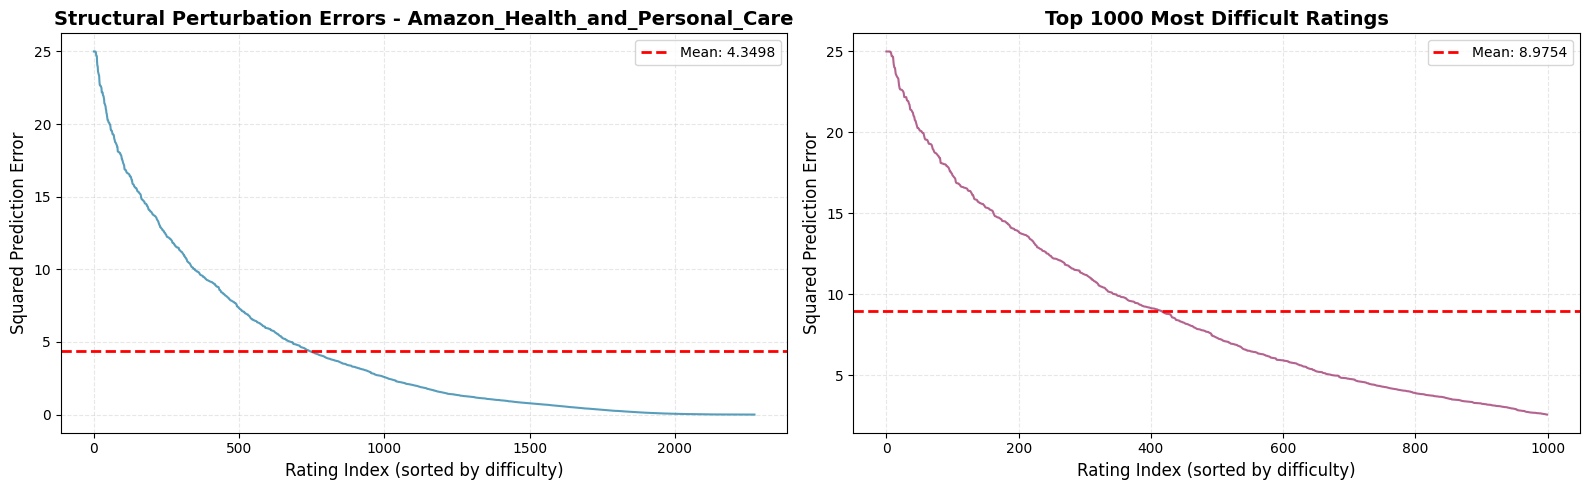


Error Distribution Percentiles:
  10th percentile: 0.0346
  25th percentile: 0.4021
  50th percentile: 1.8437
  75th percentile: 6.3137
  90th percentile: 12.9727
  95th percentile: 16.6496
  99th percentile: 22.6386


In [73]:
# Create visualization of error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: All errors in descending order
axes[0].plot(errors_sorted, linewidth=1.5, color='#2E86AB', alpha=0.8)
axes[0].set_xlabel("Rating Index (sorted by difficulty)", fontsize=12)
axes[0].set_ylabel("Squared Prediction Error", fontsize=12)
axes[0].set_title(f"Structural Perturbation Errors - {DATASET_NAME}", fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].axhline(y=errors_sorted.mean(), color='red', linestyle='--', 
                label=f'Mean: {errors_sorted.mean():.4f}', linewidth=2)
axes[0].legend(fontsize=10)

# Plot 2: Top 1000 most difficult ratings (zoomed in)
top_n = min(1000, len(errors_sorted))
axes[1].plot(errors_sorted[:top_n], linewidth=1.5, color='#A23B72', alpha=0.8)
axes[1].set_xlabel("Rating Index (sorted by difficulty)", fontsize=12)
axes[1].set_ylabel("Squared Prediction Error", fontsize=12)
axes[1].set_title(f"Top {top_n} Most Difficult Ratings", fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].axhline(y=errors_sorted[:top_n].mean(), color='red', linestyle='--',
                label=f'Mean: {errors_sorted[:top_n].mean():.4f}', linewidth=2)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print distribution percentiles
print("\nError Distribution Percentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    value = np.percentile(errors_sorted, p)
    print(f"  {p}th percentile: {value:.4f}")

## Model Training and Evaluation Functions

In [74]:
# Train RecBole model on full training data (for baseline comparison)
# This cell uses the OLD train_model function and will be skipped
# The fair experiment in Cell 17 uses the NEW train_model_with_fixed_test function

print("Skipping baseline training - use Cell 17 for fair experiment with global test set")
print("The fair experiment ensures all models use the same test set for comparison.")

Skipping baseline training - use Cell 17 for fair experiment with global test set
The fair experiment ensures all models use the same test set for comparison.


In [75]:
# =========================================================================
# EXPERIMENT: Difficult vs Random Sampling Across Training Data Percentages
# =========================================================================

# Experiment configuration
PERCENTAGES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# PERCENTAGES = [100]
EVAL_K = 10
RANDOM_SEED = 42

print(f"Experiment Configuration:")
print(f"  Percentages to test: {PERCENTAGES}")
print(f"  Global training pool: {len(global_train_df):,} ratings (for sampling)")
print(f"  Global test set: {len(global_test_df):,} ratings (shared for all)")
print(f"  Evaluation metric: Precision@{EVAL_K}, NDCG@{EVAL_K}, MAP@{EVAL_K}")
print(f"  Random seed: {RANDOM_SEED}")

Experiment Configuration:
  Percentages to test: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  Global training pool: 2,275 ratings (for sampling)
  Global test set: 532 ratings (shared for all)
  Evaluation metric: Precision@10, NDCG@10, MAP@10
  Random seed: 42


In [86]:
# Initialize results storage
results = {
    'percentage': [],
    'strategy': [],
    'precision': [],
    'ndcg': [],
    'map': [],
    'n_ratings': []
}

np.random.seed(RANDOM_SEED)

print("\nRunning fair experiment with global test set...")
print("=" * 80)
print(f"Global train pool: {len(global_train_df):,} ratings")
print(f"Global test set: {len(global_test_df):,} ratings (SAME for all models)")
print("=" * 80)

for pct in PERCENTAGES:
    # Calculate sample size from global_train (not train_df)
    n_samples = int(len(global_train_df) * pct / 100)
    print(f"\nProcessing {pct}% ({n_samples:,} ratings from global train)...")

    # Strategy 1: DIFFICULT SAMPLING
    print(f"  [1/3] Training on difficult samples...", end=" ")

    # Filter indices to only those in global_train_df
    global_train_indices = set(global_train_df.index)
    indices_sorted_filtered = [
        idx for idx in indices_sorted
        if idx in global_train_indices
    ][:n_samples]

    difficult_df = global_train_df.loc[indices_sorted_filtered]
    difficult_df = difficult_df.sample(frac=1) # Shuffle to avoid any ordering effects

    model_diff, config_diff, trainer_diff, dataset_diff, test_data_diff = \
        train_model_with_fixed_test(
            difficult_df, global_test_df, model_type=MODEL_TYPE
        )

    prec_diff, ndcg_diff, map_diff = evaluate_model(
        model_diff, config_diff, trainer_diff, test_data_diff, k=EVAL_K
    )

    results['percentage'].append(pct)
    results['strategy'].append('difficult')
    results['precision'].append(prec_diff)
    results['ndcg'].append(ndcg_diff)
    results['map'].append(map_diff)
    results['n_ratings'].append(n_samples)

    print(f"Done (P@{EVAL_K}={prec_diff:.4f})")

    # Strategy 2: RANDOM SAMPLING
    print(f"  [2/3] Training on random samples...", end=" ")

    random_indices = np.random.choice(
        global_train_df.index,
        size=n_samples,
        replace=False
    )
    random_df = global_train_df.loc[random_indices]
    random_df = random_df.sample(frac=1) # Shuffle to avoid any ordering effects


    model_rand, config_rand, trainer_rand, dataset_rand, test_data_rand = \
        train_model_with_fixed_test(
            random_df, global_test_df, model_type=MODEL_TYPE
        )

    prec_rand, ndcg_rand, map_rand = evaluate_model(
        model_rand, config_rand, trainer_rand, test_data_rand, k=EVAL_K
    )

    results['percentage'].append(pct)
    results['strategy'].append('random')
    results['precision'].append(prec_rand)
    results['ndcg'].append(ndcg_rand)
    results['map'].append(map_rand)
    results['n_ratings'].append(n_samples)

    print(f"Done (P@{EVAL_K}={prec_rand:.4f})")

    # Strategy 3: INVERSE DIFFICULT SAMPLING
    print(f"  [3/3] Training on easiest samples...", end=" ")

    indices_sorted_filtered_inv = [
        idx for idx in indices_sorted_inverted
        if idx in global_train_indices
    ][:n_samples]

    easy_df = global_train_df.loc[indices_sorted_filtered_inv]
    easy_df = easy_df.sample(frac=1) # Shuffle to avoid any ordering effects


    model_easy, config_easy, trainer_easy, dataset_easy, test_data_easy = \
        train_model_with_fixed_test(
            easy_df, global_test_df, model_type=MODEL_TYPE
        )

    prec_easy, ndcg_easy, map_easy = evaluate_model(
        model_easy, config_easy, trainer_easy, test_data_easy, k=EVAL_K
    )

    results['percentage'].append(pct)
    results['strategy'].append('difficult_inverse')
    results['precision'].append(prec_easy)
    results['ndcg'].append(ndcg_easy)
    results['map'].append(map_easy)
    results['n_ratings'].append(n_samples)

    print(f"Done (P@{EVAL_K}={prec_easy:.4f})")

print("\n" + "=" * 80)
print("Fair experiment completed!")

# Convert to DataFrame for easier manipulation
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df.to_string(index=False))


Running fair experiment with global test set...
Global train pool: 2,275 ratings
Global test set: 532 ratings (SAME for all models)

Processing 10% (227 ratings from global train)...
  [1/3] Training on difficult samples... Done (P@10=0.0024)
  [2/3] Training on random samples... Done (P@10=0.0030)
  [3/3] Training on easiest samples... Done (P@10=0.0048)

Processing 20% (455 ratings from global train)...
  [1/3] Training on difficult samples... Done (P@10=0.0023)
  [2/3] Training on random samples... Done (P@10=0.0021)
  [3/3] Training on easiest samples... Done (P@10=0.0037)

Processing 30% (682 ratings from global train)...
  [1/3] Training on difficult samples... Done (P@10=0.0034)
  [2/3] Training on random samples... Done (P@10=0.0036)
  [3/3] Training on easiest samples... Done (P@10=0.0059)

Processing 40% (910 ratings from global train)...
  [1/3] Training on difficult samples... Done (P@10=0.0037)
  [2/3] Training on random samples... Done (P@10=0.0037)
  [3/3] Training on e

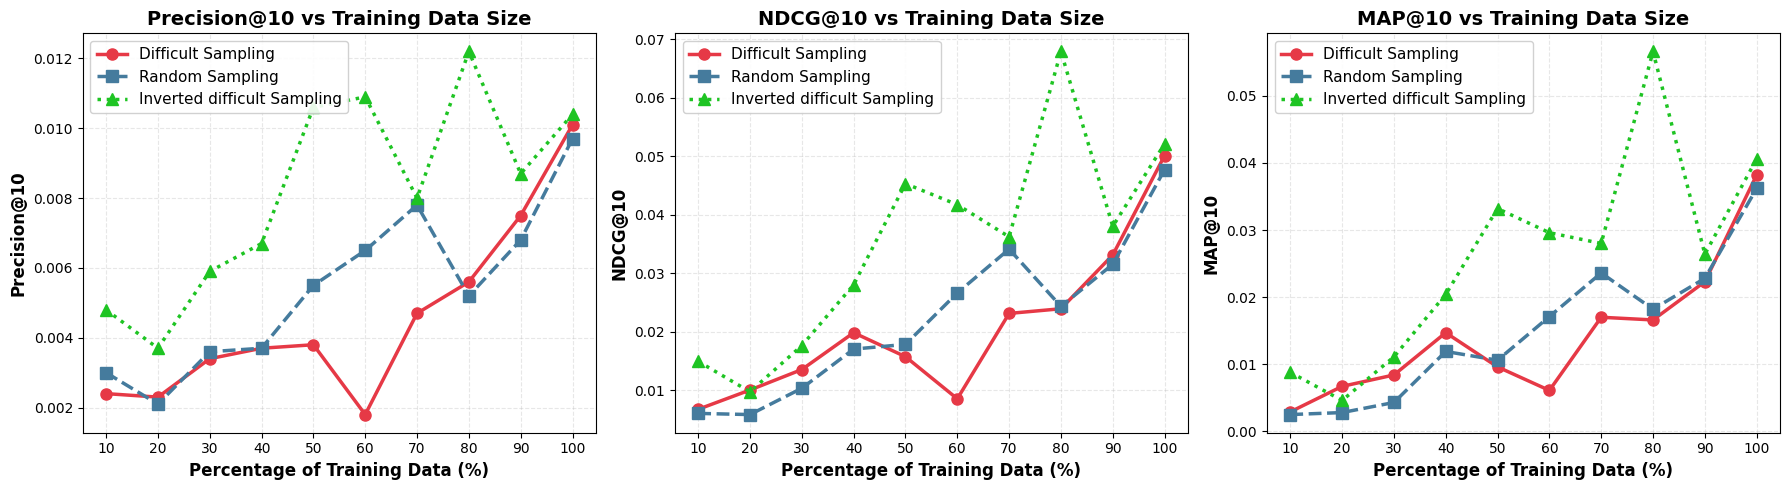


Visualization saved as 'difficult_vs_random_sampling.png'


In [87]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Separate data by strategy
difficult_results = results_df[results_df['strategy'] == 'difficult'].sort_values('percentage')
random_results = results_df[results_df['strategy'] == 'random'].sort_values('percentage')
difficult_results_inverted = results_df[results_df['strategy'] == 'difficult_inverse'].sort_values('percentage')


# Color scheme
color_difficult = '#E63946'  # Red for difficult
color_random = '#457B9D'     # Blue for random
color_difficult_inverted = "#1EC423"     # Blue for random

# Plot 1: Precision@k
axes[0].plot(difficult_results['percentage'], difficult_results['precision'],
             marker='o', linewidth=2.5, markersize=8,
             color=color_difficult, label='Difficult Sampling', linestyle='-')
axes[0].plot(random_results['percentage'], random_results['precision'],
             marker='s', linewidth=2.5, markersize=8,
             color=color_random, label='Random Sampling', linestyle='--')
axes[0].plot(difficult_results_inverted['percentage'], difficult_results_inverted['precision'],
             marker='^', linewidth=2.5, markersize=8,
             color=color_difficult_inverted, label='Inverted difficult Sampling', linestyle=':')

axes[0].set_xlabel('Percentage of Training Data (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'Precision@{EVAL_K}', fontsize=12, fontweight='bold')
axes[0].set_title(f'Precision@{EVAL_K} vs Training Data Size', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11, loc='best', framealpha=0.9)
axes[0].set_xticks(PERCENTAGES)

# Plot 2: NDCG@k
axes[1].plot(difficult_results['percentage'], difficult_results['ndcg'],
             marker='o', linewidth=2.5, markersize=8,
             color=color_difficult, label='Difficult Sampling', linestyle='-')
axes[1].plot(random_results['percentage'], random_results['ndcg'],
             marker='s', linewidth=2.5, markersize=8,
             color=color_random, label='Random Sampling', linestyle='--')
axes[1].plot(difficult_results_inverted['percentage'], difficult_results_inverted['ndcg'],
             marker='^', linewidth=2.5, markersize=8,
             color=color_difficult_inverted, label='Inverted difficult Sampling', linestyle=':')

axes[1].set_xlabel('Percentage of Training Data (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'NDCG@{EVAL_K}', fontsize=12, fontweight='bold')
axes[1].set_title(f'NDCG@{EVAL_K} vs Training Data Size', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].legend(fontsize=11, loc='best', framealpha=0.9)
axes[1].set_xticks(PERCENTAGES)

# Plot 3: MAP@k
axes[2].plot(difficult_results['percentage'], difficult_results['map'],
             marker='o', linewidth=2.5, markersize=8,
             color=color_difficult, label='Difficult Sampling', linestyle='-')
axes[2].plot(random_results['percentage'], random_results['map'],
             marker='s', linewidth=2.5, markersize=8,
             color=color_random, label='Random Sampling', linestyle='--')

axes[2].plot(difficult_results_inverted['percentage'], difficult_results_inverted['map'],
             marker='^', linewidth=2.5, markersize=8,
             color=color_difficult_inverted, label='Inverted difficult Sampling', linestyle=':')

axes[2].set_xlabel('Percentage of Training Data (%)', fontsize=12, fontweight='bold')
axes[2].set_ylabel(f'MAP@{EVAL_K}', fontsize=12, fontweight='bold')
axes[2].set_title(f'MAP@{EVAL_K} vs Training Data Size', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].legend(fontsize=11, loc='best', framealpha=0.9)
axes[2].set_xticks(PERCENTAGES)

plt.tight_layout()
plt.savefig('difficult_vs_random_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'difficult_vs_random_sampling.png'")